# Detekcja krawędzi

## Cel ćwiczenia

- Zapoznanie z metodami detekcji krawędzi:
    - Sobel, Prewitt, Roberts - przypomnienie,
    - Laplasjan z Gaussa (LoG – ang. Laplacian of Gaussian),
    - Canny.

Detekcja krawędzi przez wiele lat była podstawą algorytmów segmentacji.
Krawędzie wykrywane są najczęściej z wykorzystaniem pierwszej (gradient) i drugiej (Laplasjan) pochodnej przestrzennej.
Wykorzystanie obu metod zaprezentowane zostało w ćwiczeniu *Przetwarzanie wstępne. Filtracja kontekstowa*.

W niniejszym ćwiczeniu poznane detektory krawędzi zostaną porównane z bardziej zaawansowanymi: Laplasjan z funkcji Gaussa (LoG), Zero Crossing i Canny.

## Laplasjan z Gaussa (LoG)

Funkcja Gaussa:<br>
\begin{equation}
h(r) = e^{\frac{-r^2}{2 \sigma^2}}
\end{equation}<br>
gdzie:
- $r^2 = x^2 + y^2$
- $\sigma$ to odchylenie standardowe.

Działanie filtracji Gaussowskiej zostało przedstawione w ćwiczeniu "Przetwarzanie wstępne". W jej wyniku następuje rozmazanie obrazu.
Laplasjan tej funkcji dany jest wzorem:

\begin{equation}
\nabla^2 h(r) = \frac{r^2 - 2\sigma^2}{\sigma^4} e^{-\frac{r^2}{2\sigma^2}}
\end{equation}

Funkcję (z oczywistych powodów) nazywamy Laplasjan z Gaussa (LoG).
Ponieważ druga pochodna jest operacją liniową, konwolucja obrazu z $\nabla^2 h(r)$ daje taki sam efekt jak zastosowanie filtracji Gaussa na obrazie, a następnie obliczenie Laplasjanu z wyniku.
Lokalizacja krawędzi polega na znalezieniu miejsca, gdzie po filtracji LoG następuje zmiana znaku.

1. Wczytaj obraz *house.png*.
2. Wykonaj rozmycie Gaussowskie obrazu wejściowego.
W tym celu wykorzysaj funkcję `cv2.GaussianBlur(img, kSize, sigma)`.
Pierwszy argument jest obrazem wejśćiowym.
Drugi jest rozmiarem filtru (podanym w nawiasach okrągłych, np. *(3, 3)*).
Trzecim argumentem jest odchylenie standardowe. Wartość jest dobrana automatycznie, jeśli zosanie podana wartość `0` (będą równe rozmiarowi).
3. Oblicz laplasjan obrazu rozmytego.
W tym celu wykorzysaj funkcję `cv2.Laplacian(img, ddepth)`.
Pierszym argumentem jest obraz wejściowy.
Drugim argumentem jest typ danych wejściowych. Użyj `cv2.CV_32F`.
4. Wyznacz miejsca zmiany znaku.
Zaimplementuj funkcję `crossing(LoG, thr)`:
    - Najpierw stwórz tablicę, do której zostanie zapisany wynik.
    Jej rozmiar jest taki sam jak przetwarzanego obrazu.
    - Następnie wykonaj pętle po obrazie (bez ramki jednopikselowej).
    W każdej iteracji stwórz otoczenie o rozmiarze $3 \times 3$.
    Dla otoczenia oblicz wartość maksymalną i minimalną.
    - Jeśli wartości te mają przeciwne znaki, to do danego miejsca tablicy przypisz wartość:
        - jeśli piksel wejściowy > 0, to dodaj do niego wartość bezwzględną minimum.
        - jeśli piksel wejściowy < 0, to do jego wartości bezwzględnej dodaj maksimum.
    - Zmień zakres wykonanej tablicy do $<0, 255>$.
    - Wykonaj progowanie tablicy. Próg jest argumentem wejściowym.
    - Przeskaluj dane binarne do wartości `[0, 255]`.
    - Wykonaj konwersję do typu *uint8*.
    - Wykonaj rozmycie medianowe wyniku.
    Wykorzystaj funkcję `cv2.medianBlur(img, kSize)`.
    Pierwszym argumentem jest obraz wejśćiowy, a drugim rozmiar filtra.
    - Zwróć wyznaczoną tablicę.
5. Wyświetl obraz wynikowy.
6. Dobierz parametry (rozmiar filtru Gaussa, odchylenie standardowe, próg binaryzacji) tak, by widoczne były kontury domu, ale nie dachówki.

In [ ]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
import math
import os
import requests

url = 'https://raw.githubusercontent.com/vision-agh/poc_sw/master/09_Canny/'

fileNames = ["dom.png"]
for fileName in fileNames:
  if not os.path.exists(fileName):
      r = requests.get(url + fileName, allow_redirects=True)
      open(fileName, 'wb').write(r.content)



In [ ]:
#1
house = cv2.imread('dom.png', cv2.IMREAD_GRAYSCALE)

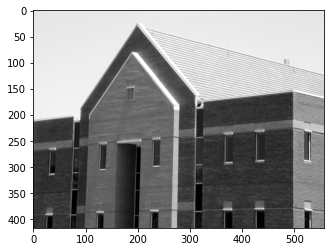

In [ ]:
plt.imshow(house, 'gray')

In [ ]:
#2
g_house = cv2.GaussianBlur(house, (3,3), 0)

In [ ]:
#3
lap_house = cv2.Laplacian(g_house, cv2.CV_32F)

In [ ]:
#4
def crossing(log, thr):
  height, width = log.shape
  tab = np.zeros((height, width))
  for i in range(1, height-1):
    for j in range (1, width-1):
      arr =log[i-1:i+1, j-1:j+1]
      max = np.max(arr)
      min = np.min(arr)

      if min < 0 and max > 0:
        if log[i,j] > 0:
          tab[i,j]=np.abs(min) + log[i,j]

        if log[i,j] < 0:
          tab[i,j] = np.abs(log[i,j]) + max
  
  tab = cv2.normalize(tab, None, 0, 255, cv2.NORM_MINMAX)
  tab_bin = (tab > thr).astype(np.uint8)
  tab_bin = cv2.normalize(tab_bin, None, 0, 255, cv2.NORM_MINMAX)
  tab_bin = tab_bin.astype(np.uint8)
  blur = cv2.medianBlur(tab_bin, 1)
  return blur

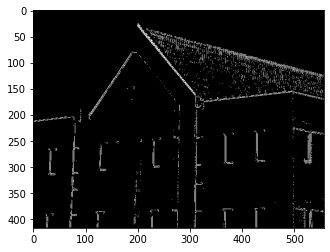

In [ ]:
cross = crossing(lap_house, 80)
plt.imshow(cross, 'gray')

## Algorytm Canny'ego

> Algorytm Canny'ego to często wykorzystywana metoda detekcji krawędzi.
> Zaproponowana została w 1986r. przez Johna F. Cannego.
> Przy jego projektowaniu założono trzy cele:
> - niska liczba błędów - algorytm powinien znajdywać wszystkie krawędzie oraz generować jak najmniej fałszywych detekcji,
> - punkty krawędziowe powinny być poprawnie lokalizowane - wykryte punkty powinny być jak najbardziej zbliżone do rzeczywistych,
> - krawędzie o szerokości 1 piksela - algorytm powinien zwrócić jeden punkt dla każdej rzeczywistej krawędzi.

Zaimplementuj algorytm detekcji krawędziCanny'ego:
1. W pierwszym kroku obraz przefiltruj dwuwymiarowym filtrem Gaussa.
2. Następnie oblicz gradient pionowy i poziomy ($g_x $ i $g_y$).
Jedną z metod jest filtracja Sobela.
3. Dalej oblicz amplitudę:
$M(x,y)  = \sqrt{g_x^2+g_y^2}$ oraz kąt:
$\alpha(x,y) = arctan(\frac{g_y}{g_x})$.
Do obliczenia kąta wykorzystaj funkcję `np.arctan2(x1, x2)`.
Wynik jest w radianach.
4. W kolejnym etapie wykonaj kwantyzację kątów gradientu.
Kąty od $-180^\circ$ do $180^\circ$ można podzielić na 8 przedziałów:
[$-22.5^\circ, 22.5^\circ$], [$22.5^\circ, 67.5^\circ$],
[$67.5^\circ, 112.5^\circ$], [$112.5^\circ, 157.5^\circ$],
[$157.5^\circ, -157.5^\circ$], [$-157.5^\circ, -112.5^\circ$],
[$-112.5^\circ, -67.5^\circ$], [$-67.5^\circ, -22.5^\circ$].
Przy czym należy rozpatrywać tylko 4 kierunki:
    - pionowy ($d_1$),
    - poziomy ($d_2$),
    - skośny lewy ($d_3$),
    - skośny prawy ($d_4$).
5. Dalej przeprowadź eliminację pikseli, które nie mają wartości maksymalnej (ang. *nonmaximal suppresion*).
Celem tej operacji jest redukcja szerokości krawędzi do rozmiaru 1 piksela.
Algorytm przebiega następująco.
W rozpatrywanym otoczeniu o rozmiarze $3 \times 3$:
    - określ do którego przedziału należy kierunek gradientu piksela centralnego ($d_1, d_2, d_3, d_4$).
    - przeanalizuje sąsiadów leżących na tym kierunku.
Jeśli choć jeden z nich ma amplitudę większą niż piksel centralny, to należy uznać, że nie jest lokalnym maksimum i do wyniku przypisać $g_N(x,y) = 0$.
W przeciwnym przypadku $g_N(x,y) = M(x,y)$.
Przez $g_N$ rozumiemy obraz detekcji lokalnych maksimów.
Zaimplementuj funkcję `nonmax`.
Pierwszym argementem jest macierz kierunków (po kwantyzacji).
Drugim argumentem jest macierz amplitudy.
6. Ostatnią operacją jest binaryzacja obrazu $g_N$.
Stosuje się tutaj tzw. binaryzację z histerezą.
Wykorzystuje się w niej dwa progi: $T_L$ i $T_H$, przy czym $T_L < T_H$.
Canny zaproponował, aby stosunek progu wyższego do niższego był jak 3 lub 2 do 1.
Rezultaty binaryzacji można opisać jako:<br>
$g_{NH}(x,y) = g_N(x,y) \geq TH $<br>
$g_{NL}(x,y) = TH > g_N(x,y) \geq TL $<br>
Można powiedzieć, że na obrazie $g_{NH}$ są "pewne" krawędzie.
Natomiast na $g_{NL}$ "potencjalne".
Często krawędzie "pewne" nie są ciągłe.
Dlatego wykorzystuje się obraz $g_{NL}$ w następującej procedurze:
    - Stwórz stos zawierający wszystkie piksele zaznaczone na obrazie $g_{NH}$.
W tym celu wykorzystaj listę współrzędnych `[row, col]`.
Do pobrania elementu z początku służy metoda `list.pop()`.
Do dodania elementu na koniec listy służy metoda `list.append(new)`.
    - Stwórz obraz, który będzie zawierał informację czy dany piksel został już odwiedzony.
    - Stwórz obraz, któy zawierać będzie wynikowe krawędzie.
Jej rozmiar jest równy rozmiarowi obrazu.
    - Wykonaj pętlę, która będzie pobierać elementy z listy, dopóki ta nie będzie pusta.
W tym celu najlepiej sprawdzi się pętla `while`.
    - W każdej iteracji pobierz element ze stosu.
    - Sprawdź czy dany element został już odwiedzony.
    - Jeśli nie został, to:
        - Oznacz go jako odwiedzony,
        - Oznacz piksel jako krawędź w wyniku,
        - Sprawdź otoczenie piksela w obrazie $g_{NL}$,
        - Dodaj do stosu współrzędne otoczenia, które zawierają krawędź (potencjalną).
        Można to wykoanać np. pętlą po stworzonym otoczeniu.
7. Wyświetl obraz oryginalny, obraz $g_{NH}$ oraz obraz wynikowy.

Pomocnicze obrazy $g_{NH}$ i $g_{NL}$ zostały wprowadzone dla uproszczenia opisu.
Algorytm można zaimplementować wbardziej "zwarty" sposób.

Na podstawie powyższego opisu zaimplementuj algorytm Cannego.

In [ ]:
def nonmax(direct, amp):
    Y, X = direct.shape
    GN = np.zeros((Y, X))
    for y in range(1, Y - 1):
        for x in range(1, X - 1):
            if direct[y, x] == 1:
                if (amp[y, x-1] > amp[y, x] or amp[y, x+1] > amp[y, x]):
                    GN[y, x] = 0
                else:
                    GN[y, x] = amp[y, x]
            elif direct[y, x] == 2:
                if (amp[y+1, x-1] > amp[y, x] or amp[y-1, x+1] > amp[y, x]):
                    GN[y, x] = 0
                else:
                    GN[y, x] = amp[y, x]
            elif direct[y, x] == 3:
                if amp[y+1, x] > amp[y, x] or amp[y-1, x] > amp[y, x]:
                    GN[y, x] = 0
                else:
                    GN[y, x] = amp[y, x]
            elif direct[y, x] == 4:
                if (amp[y-1, x-1] > amp[y, x] or amp[y+1, x+1] > amp[y, x]):
                    GN[y, x] = 0
                else:
                    GN[y, x] = amp[y, x]
    return GN


In [ ]:
def canny_detector(img, TL, TH):
    Y, X = img.shape
    img = cv2.GaussianBlur(img, (3, 3), 0)
    g_x = cv2.Sobel(img, cv2.CV_32F, 1, 0, ksize=3)
    g_y = cv2.Sobel(img, cv2.CV_32F, 0, 1, ksize=3)
    mag = np.sqrt(g_y**2 + g_x**2)
    ang = np.arctan2(g_y, g_x)
    ang = np.degrees(ang)
    for j in range(ang.shape[0]):
      for i in range(ang.shape[1]):
        if ang[j,i] < 0:
          ang[j,i] += 180

    angs = np.zeros((Y,X))
    for y in range(Y):
        for x in range(X):
            if (0 <= ang[y, x] < 22.5) or (157.5 <= ang[y, x] <= 180):
                angs[y, x] = 1
            elif (22.5 <= ang[y, x] < 67.5):
                angs[y, x] = 2
            elif (67.5 <= ang[y, x] < 112.5):
                angs[y, x] = 3
            elif (112.5 <= ang[y, x] < 157.5):
                angs[y, x] = 4

    gN = nonmax(angs, mag)
    gNH = (gN >= TH).astype(int)
    gNL = np.where(np.logical_and(TH > gN, gN >= TL), 1, 0)

    list = []
    for y in range(Y):
        for x in range(X):
            if gNH[y, x]:
                list.append((y, x))

    visited = np.zeros((Y, X))
    res = np.zeros((Y, X))
    while (list):
        y, x = list.pop()
        if not visited[y, x]:
            visited[y, x] = 1
            res[y, x] = 255
            if y > 0 and x > 0 and gNL[y-1, x-1]:
                list.append((y-1, x-1))
            if y > 0 and gNL[y-1, x]:
                list.append((y-1, x))
            if y > 0 and x + 1 < X and gNL[y-1, x+1]:
                list.append((y-1, x+1))
            if x > 0 and gNL[y, x-1]:
                list.append((y, x-1))
            if x + 1 < X and gNL[y, x+1]:
                list.append((y, x+1))
            if y + 1 < Y and x > 0 and gNL[y+1, x-1]:
                list.append((y+1, x-1))
            if y + 1 < Y and gNL[y+1, x]:
                list.append((y+1, x))    
            if y + 1 < Y and x + 1 < X and gNL[y+1, x+1]:
                list.append((y+1, x+1))

    return gNH, res

In [ ]:
gNH, canny = canny_detector(house, 100, 200)

Text(0.5, 1.0, 'Canny')

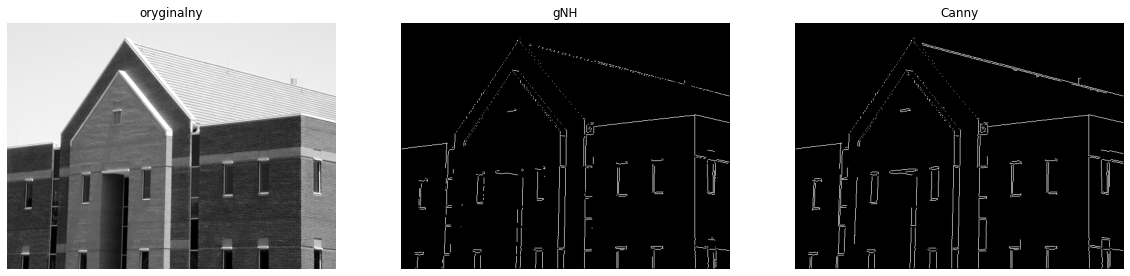

In [ ]:
fig,ax = plt.subplots(1,3)
fig.set_size_inches(20,20)
ax[0].imshow(house, 'gray')
ax[0].axis('off')
ax[0].set_title("oryginalny")
ax[1].imshow(gNH, 'gray')
ax[1].axis('off')
ax[1].set_title("gNH")
ax[2].imshow(canny, 'gray')
ax[2].axis('off')
ax[2].set_title("Canny")

## Algorytm Canny'ego - OpenCV

1. Wykonaj dektekcję krawędzi metodą Canny'ego wykorzystując funkcję `cv2.Canny`.
    - Pierwszym argumentem funkcji jest obraz wejściowy.
    - Drugim argumentem jest mniejszy próg.
    - Trzecim argumentem jest większy próg.
    - Czwarty argument to tablica, do której wpisany zostanie wynik.
    Można zwrócić go przez wartość i podać wartość `None`.
    - Piąty argument to rozmiar operatora Sobela (w naszym przypadku 3).
    - Szósty argument to rodzaj używanej normy.
    0 oznacza normę $L_1$, 1 oznacza normę $L_2$. Użyj $L_2$.
2. Wynik wyświetl i porównaj z własną implementacją.

In [ ]:
canny_cv2 = cv2.Canny(house, 100, 200,  None, 3, 1)

Text(0.5, 1.0, 'Canny mój')

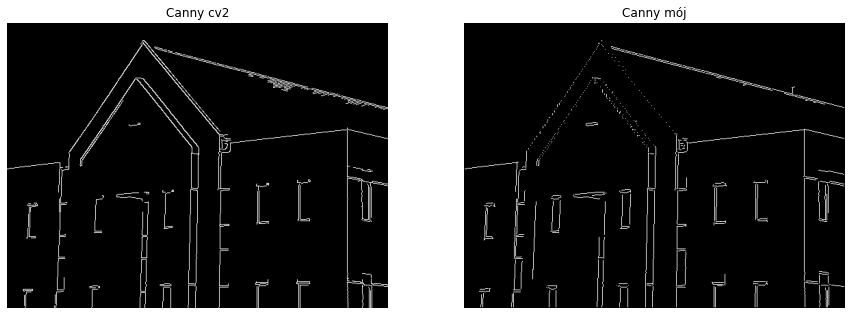

In [ ]:
fig,ax = plt.subplots(1,2)
fig.set_size_inches(15,15)
ax[0].imshow(canny_cv2, 'gray')
ax[0].axis('off')
ax[0].set_title("Canny cv2")
ax[1].imshow(canny, 'gray')
ax[1].axis('off')
ax[1].set_title("Canny mój")